In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, f1_score, roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, recall_score, precision_score, accuracy_score, roc_auc_score

In [2]:
churn_data = pd.read_excel('Churn_Data.xlsx')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


In [3]:
# One Hot Encoding Categorical Data

cols = churn_data.columns.to_list()

object_cols = []

for col in cols:
    if churn_data[col].dtype == object and col not in ['customerID', 'TotalCharges', 'Churn']:
        object_cols.append(col)

churn_data = pd.get_dummies(churn_data, columns = object_cols, drop_first = True)
churn_data.head()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn,gender_Male,Partner_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,0,0,No,0,1,...,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,0,34,56.95,1889.5,0,0,No,1,0,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,53.85,108.15,0,0,Yes,1,0,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,0,45,42.30,1840.75,0,3,No,1,0,...,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,0,2,70.70,151.65,0,0,Yes,0,0,...,0,0,0,0,0,0,1,0,1,0


In [4]:
# Handling missing data

churn_data.drop(churn_data[churn_data['TotalCharges'] == ' '].index, inplace=True)
churn_data.shape

(7032, 34)

In [5]:
churn_data['TotalCharges'] = churn_data['TotalCharges'].astype(float)

In [6]:
# Transforming the target variable from No/Yes to 0/1

churn_data['Churn'].replace(['No', 'Yes'], [0, 1], inplace = True)

In [7]:
X = churn_data.drop(['customerID', 'Churn'], axis = 1)
y = churn_data['Churn']

In [8]:
# Function to determine the optimal threshold for individual model

def find_threshold(classifier, test_data, test_labels):
    y_proba_thresh = classifier.predict_proba(test_data)[::,1]
    
    fpr, tpr, thresholds = roc_curve(test_labels, y_proba_thresh)

    y_proba = classifier.predict_proba(test_data)
    y_pred = classifier.predict(test_data)

    f1_scores = []

    for threshold in thresholds:
        y_pred = (y_proba[:, 1] > threshold).astype(int)
        f1_scores.append(f1_score(test_labels, y_pred))

    optimal_threshold = thresholds[np.argmax(f1_scores)]

    print(f"The optimum threshold is {optimal_threshold.round(3)} with an F1 score of {max(f1_scores).round(3)}")
    return optimal_threshold

In [9]:
# Function to aggregate the relevant metrics for individual model

def calculate_metrics(model_name, y_true, predictions):
    
    rscore = recall_score(y_true, predictions)
    pscore = precision_score(y_true, predictions)
    fscore = f1_score(y_true, predictions)
    rascore = roc_auc_score(y_true, predictions)

    results = [(rscore, pscore, fscore, rascore)]
    classifier_metrics = pd.DataFrame(data = results, columns=['Recall','Precision','F1 Score', 'ROC-AUC Score'])
    classifier_metrics.insert(0, 'Model', model_name)
    print(classifier_metrics)
    return classifier_metrics

In [10]:
# Train/Test split with stratify on the target variable to handle the target class imbalance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

print(X_train.shape), print(X_test.shape), print(y_train.shape), print(y_test.shape)

(5625, 32)
(1407, 32)
(5625,)
(1407,)


(None, None, None, None)

In [11]:
# Vanilla Random Forest Classifier

clf_rf = RandomForestClassifier(random_state = 42)

clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

clf_rf_metrics = calculate_metrics('Random Forest Classifier', y_test, y_pred)

                      Model    Recall  Precision  F1 Score  ROC-AUC Score
0  Random Forest Classifier  0.692513   0.737892  0.714483       0.801726


In [13]:
# Determining the optimal threshold for Vanilla Random Forest Classifier

optimal_threshold = find_threshold(clf_rf, X_test, y_test)

The optimum threshold is 0.38 with an F1 score of 0.739


In [14]:
y_proba = clf_rf.predict_proba(X_test)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)

clf_rf_thresh_metrics = calculate_metrics('Optimal Threshold Random Forest Classifier', y_test, y_pred)

                                        Model    Recall  Precision  F1 Score  \
0  Optimal Threshold Random Forest Classifier  0.799465   0.687356  0.739184   

   ROC-AUC Score  
0       0.833905  


In [18]:
# Hyperparameter tuning the Vanilla Random Forest Classifier

grid = {'max_depth': [3, 5, 6, 9],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [10, 25, 50, 100, 150]}

clf_rf = RandomForestClassifier(random_state = 42)

clf_rf_grid = GridSearchCV(clf_rf, grid, cv=8, scoring = 'f1', n_jobs = -1)
clf_rf_grid.fit(X_train, y_train)

best_params = clf_rf_grid.best_params_
best_model = clf_rf_grid.best_estimator_

print(best_params)

{'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 50}


In [19]:
clf_rf_9_1_50 = RandomForestClassifier(max_depth = 9, min_samples_leaf = 1, n_estimators = 50, random_state = 42)

clf_rf_9_1_50.fit(X_train, y_train)
y_pred = clf_rf_9_1_50.predict(X_test)

clf_rf_9_1_50_metrics = calculate_metrics('Tuned Random Forest Classifier', y_test, y_pred)

                            Model    Recall  Precision  F1 Score  \
0  Tuned Random Forest Classifier  0.700535   0.748571  0.723757   

   ROC-AUC Score  
0       0.807673  


In [20]:
# Determining the optimal threshold for the tuned Random Forest Classifier

optimal_threshold = find_threshold(clf_rf_9_1_50, X_test, y_test)

The optimum threshold is 0.318 with an F1 score of 0.744


In [21]:
y_proba = clf_rf_9_1_50.predict_proba(X_test)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)

clf_rf_9_1_50_thresh_metrics = calculate_metrics('Tuned Threshold Random Forest Classifier', y_test, y_pred)

                                      Model    Recall  Precision  F1 Score  \
0  Tuned Threshold Random Forest Classifier  0.879679   0.645098  0.744344   

   ROC-AUC Score  
0       0.852231  


In [22]:
# Metrics for the variants of the Random Forest Classifier

rf = pd.concat([clf_rf_metrics, clf_rf_thresh_metrics, clf_rf_9_1_50_metrics, clf_rf_9_1_50_thresh_metrics])
rf

,Model,Recall,Precision,F1 Score,ROC-AUC Score
0,Random Forest Classifier,0.692513,0.737892,0.714483,0.801726
0,Optimal Threshold Random Forest Classifier,0.799465,0.687356,0.739184,0.833905
0,Tuned Random Forest Classifier,0.700535,0.748571,0.723757,0.807673
0,Tuned Threshold Random Forest Classifier,0.879679,0.645098,0.744344,0.852231


In [23]:
# Vanilla Gradient Boosting Classifier

clf_gb = GradientBoostingClassifier(random_state = 42)

clf_gb.fit(X_train, y_train)
y_pred = clf_gb.predict(X_test)

clf_gb_metrics = calculate_metrics('Gradient Boosting Classifier', y_test, y_pred)

                          Model    Recall  Precision  F1 Score  ROC-AUC Score
0  Gradient Boosting Classifier  0.695187   0.738636  0.716253       0.803063


In [24]:
# Determining the optimal threshold for the Vanialla Gradient Boosting Classifier

optimal_threshold = find_threshold(clf_gb, X_test, y_test)

The optimum threshold is 0.273 with an F1 score of 0.736


In [25]:
y_proba = clf_gb.predict_proba(X_test)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)

clf_gb_thresh_metrics = calculate_metrics('Optimal Threshold Gradient Boosting Classifier', y_test, y_pred)

                                            Model    Recall  Precision  \
0  Optimal Threshold Gradient Boosting Classifier  0.871658   0.636719   

   F1 Score  ROC-AUC Score  
0  0.735892         0.8458  


In [26]:
# Hyperparameter tuning the Vanilla Gradient Boosting Classifier

grid = {'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001],
        'n_estimators': [10, 25, 50, 100, 150],
        'max_depth': [3, 5, 6, 9],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features':['auto', 'sqrt', 'log2']}

clf_gb = GradientBoostingClassifier(random_state = 42)

clf_gb_grid = GridSearchCV(clf_gb, grid, cv=8, scoring = 'f1', n_jobs = -1)
clf_gb_grid.fit(X_train, y_train)

best_params = clf_gb_grid.best_params_
best_model = clf_gb_grid.best_estimator_

print(best_params)

{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150}


In [27]:
clf_gb_gs = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 5, max_features = 'sqrt',
                                    min_samples_leaf = 2, n_estimators = 150, random_state = 42)

clf_gb_gs.fit(X_train, y_train)
y_pred = clf_gb_gs.predict(X_test)

clf_gb_gs_metrics = calculate_metrics('Tuned Gradient Boosting Classifier', y_test, y_pred)

                                Model    Recall  Precision  F1 Score  \
0  Tuned Gradient Boosting Classifier  0.695187   0.734463  0.714286   

   ROC-AUC Score  
0       0.802095  


In [28]:
# Determining the optimal threshold for the tuned Gradient Boosting Classifier

optimal_threshold = find_threshold(clf_gb_gs, X_test, y_test)

The optimum threshold is 0.234 with an F1 score of 0.742


In [29]:
y_proba = clf_gb_gs.predict_proba(X_test)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)

clf_gb_gs_thresh_metrics = calculate_metrics('Tuned Threshold Gradient Boosting Classifier', y_test, y_pred)

                                          Model    Recall  Precision  \
0  Tuned Threshold Gradient Boosting Classifier  0.919786   0.622061   

   F1 Score  ROC-AUC Score  
0  0.742179       0.858731  


In [30]:
# Metrics for the variants of the Gradient Boosting Classifier

gb = pd.concat([clf_gb_metrics, clf_gb_thresh_metrics, clf_gb_gs_metrics, clf_gb_gs_thresh_metrics])
gb

,Model,Recall,Precision,F1 Score,ROC-AUC Score
0,Gradient Boosting Classifier,0.695187,0.738636,0.716253,0.803063
0,Optimal Threshold Gradient Boosting Classifier,0.871658,0.636719,0.735892,0.845800
0,Tuned Gradient Boosting Classifier,0.695187,0.734463,0.714286,0.802095
0,Tuned Threshold Gradient Boosting Classifier,0.919786,0.622061,0.742179,0.858731


In [35]:
rf_gb = pd.concat([rf, gb])
rf_gb.sort_values('F1 Score', ascending =  False)

,Model,Recall,Precision,F1 Score,ROC-AUC Score
0,Tuned Threshold Random Forest Classifier,0.879679,0.645098,0.744344,0.852231
0,Tuned Threshold Gradient Boosting Classifier,0.919786,0.622061,0.742179,0.858731
0,Optimal Threshold Random Forest Classifier,0.799465,0.687356,0.739184,0.833905
0,Optimal Threshold Gradient Boosting Classifier,0.871658,0.636719,0.735892,0.845800
0,Tuned Random Forest Classifier,0.700535,0.748571,0.723757,0.807673
0,Gradient Boosting Classifier,0.695187,0.738636,0.716253,0.803063
0,Random Forest Classifier,0.692513,0.737892,0.714483,0.801726
0,Tuned Gradient Boosting Classifier,0.695187,0.734463,0.714286,0.802095


In [36]:
# Vanilla XGBoost Classifier

clf_xgb = xgb.XGBClassifier(random_state = 42)

clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)

clf_xgb_metrics = calculate_metrics('XGB Classifier', y_test, y_pred)

            Model    Recall  Precision  F1 Score  ROC-AUC Score
0  XGB Classifier  0.681818   0.708333  0.694823       0.790086


In [37]:
# Determining the optimal threshold for the Vanilla XGBoost Classifier

optimal_threshold = find_threshold(clf_xgb, X_test, y_test)

The optimum threshold is 0.3050000071525574 with an F1 score of 0.715


In [38]:
y_proba = clf_xgb.predict_proba(X_test)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)

clf_xgb_thresh_metrics = calculate_metrics('Optimal Threshold XGB Classifier', y_test, y_pred)

                              Model    Recall  Precision  F1 Score  \
0  Optimal Threshold XGB Classifier  0.802139   0.645161  0.715137   

   ROC-AUC Score  
0       0.821205  


In [70]:
# Hyperparameter tuning the Vanilla XGBoost Classifier

grid = {'n_estimators': [10, 25, 50, 100, 150],
              'max_depth': [3, 5, 7, 9],
              'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001],
              'lambda': [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]}

clf_xgb = xgb.XGBClassifier(random_state = 42)

clf_xgb_grid = GridSearchCV(clf_xgb, grid, cv=8, scoring = 'f1', n_jobs = -1)
clf_xgb_grid.fit(X_train, y_train)

best_params = clf_xgb_grid.best_params_
best_model = clf_xgb_grid.best_estimator_

print(best_params)

{'lambda': 0.05, 'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 50}


In [73]:
clf_xgb_gs = xgb.XGBClassifier(reg_lambda = 0.05, learning_rate = 0.25, max_depth = 3, n_estimators = 50,
                               random_state = 42)

clf_xgb_gs.fit(X_train, y_train)
y_pred = clf_xgb_gs.predict(X_test)

clf_xgb_gs_metrics = calculate_metrics('Tuned XGB Classifier', y_test, y_pred)

                  Model    Recall  Precision  F1 Score  ROC-AUC Score
0  Tuned XGB Classifier  0.705882   0.741573  0.723288       0.808411


In [74]:
# Determining the optimal threshold for the tuned XGBoost Classifier

optimal_threshold = find_threshold(clf_xgb_gs, X_test, y_test)

The optimum threshold is 0.25 with an F1 score of 0.733


In [75]:
y_proba = clf_xgb_gs.predict_proba(X_test)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)

clf_xgb_gs_thresh_metrics = calculate_metrics('Tuned Threshold XGB Classifier', y_test, y_pred)

                            Model    Recall  Precision  F1 Score  \
0  Tuned Threshold XGB Classifier  0.898396   0.618785  0.732824   

   ROC-AUC Score  
0       0.849004  


In [76]:
# Metrics for the variants of the XGBoost Classifier

xgboo = pd.concat([clf_xgb_metrics, clf_xgb_thresh_metrics, clf_xgb_gs_metrics, clf_xgb_gs_thresh_metrics])
xgboo

,Model,Recall,Precision,F1 Score,ROC-AUC Score
0,XGB Classifier,0.681818,0.708333,0.694823,0.790086
0,Optimal Threshold XGB Classifier,0.802139,0.645161,0.715137,0.821205
0,Tuned XGB Classifier,0.705882,0.741573,0.723288,0.808411
0,Tuned Threshold XGB Classifier,0.898396,0.618785,0.732824,0.849004


In [78]:
rf_gb_xgboo = pd.concat([rf, gb, xgboo])
rf_gb_xgboo.sort_values('F1 Score', ascending =  False)

,Model,Recall,Precision,F1 Score,ROC-AUC Score
0,Tuned Threshold Random Forest Classifier,0.879679,0.645098,0.744344,0.852231
0,Tuned Threshold Gradient Boosting Classifier,0.919786,0.622061,0.742179,0.858731
0,Optimal Threshold Random Forest Classifier,0.799465,0.687356,0.739184,0.833905
0,Optimal Threshold Gradient Boosting Classifier,0.871658,0.636719,0.735892,0.845800
0,Tuned Threshold XGB Classifier,0.898396,0.618785,0.732824,0.849004
0,Tuned Random Forest Classifier,0.700535,0.748571,0.723757,0.807673
0,Tuned XGB Classifier,0.705882,0.741573,0.723288,0.808411
0,Gradient Boosting Classifier,0.695187,0.738636,0.716253,0.803063
0,Optimal Threshold XGB Classifier,0.802139,0.645161,0.715137,0.821205
0,Random Forest Classifier,0.692513,0.737892,0.714483,0.801726


In [79]:
# Vanilla AdaBoost Classifier

clf_ada = AdaBoostClassifier(random_state = 42)

clf_ada.fit(X_train, y_train)
y_pred = clf_ada.predict(X_test)

clf_ada_metrics = calculate_metrics('AdaBoost Classifier', y_test, y_pred)

                 Model   Recall  Precision  F1 Score  ROC-AUC Score
0  AdaBoost Classifier  0.71123   0.732782  0.721845       0.808664


In [80]:
# Determining the optimal threshold for the Vanilla AdaBoost Classifier

optimal_threshold = find_threshold(clf_ada, X_test, y_test)

The optimum threshold is 0.497 with an F1 score of 0.738


In [81]:
y_proba = clf_ada.predict_proba(X_test)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)

clf_ada_thresh_metrics = calculate_metrics('Optimal Threshold AdaBoost Classifier', y_test, y_pred)

                                   Model    Recall  Precision  F1 Score  \
0  Optimal Threshold AdaBoost Classifier  0.815508   0.674779  0.738499   

   ROC-AUC Score  
0       0.836602  


In [82]:
# Hyperparameter tuning the Vanilla AdaBoost Classifier

grid = {'n_estimators': [10, 20, 25, 50, 100, 150],
        'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]}

clf_ada = AdaBoostClassifier(random_state = 42)

clf_ada_grid = GridSearchCV(clf_ada, grid, cv=8, scoring = 'f1', n_jobs = -1)
clf_ada_grid.fit(X_train, y_train)

best_params = clf_ada_grid.best_params_
best_model = clf_ada_grid.best_estimator_

print(best_params)

{'learning_rate': 0.5, 'n_estimators': 150}


In [83]:
clf_ada_gs = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 150,random_state = 42)

clf_ada_gs.fit(X_train, y_train)
y_pred = clf_ada_gs.predict(X_test)

clf_ada_gs_metrics = calculate_metrics('Tuned AdaBoost Classifier', y_test, y_pred)

                       Model    Recall  Precision  F1 Score  ROC-AUC Score
0  Tuned AdaBoost Classifier  0.705882   0.717391   0.71159       0.802602


In [84]:
# Determining the optimal threshold for the tuned AdaBoost Classifier

optimal_threshold = find_threshold(clf_ada_gs, X_test, y_test)

The optimum threshold is 0.497 with an F1 score of 0.739


In [85]:
y_proba = clf_ada_gs.predict_proba(X_test)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)

clf_ada_gs_thresh_metrics = calculate_metrics('Tuned Threshold AdaBoost Classifier', y_test, y_pred)

                                 Model    Recall  Precision  F1 Score  \
0  Tuned Threshold AdaBoost Classifier  0.887701   0.632381  0.738598   

   ROC-AUC Score  
0       0.850433  


In [67]:
# Metrics for the variants of the AdaBoost Classifier

ada = pd.concat([clf_ada_metrics, clf_ada_thresh_metrics, clf_ada_gs_metrics, clf_ada_gs_thresh_metrics])
ada

,Model,Recall,Precision,F1 Score,ROC-AUC Score
0,AdaBoost Classifier,0.711230,0.732782,0.721845,0.808664
0,Optimal Threshold AdaBoost Classifier,0.815508,0.674779,0.738499,0.836602
0,Tuned AdaBoost Classifier,0.705882,0.717391,0.711590,0.802602
0,Tuned Threshold AdaBoost Classifier,0.887701,0.632381,0.738598,0.850433


In [86]:
# Metrics for the variants of the Ensemble Classifiers

rf_gb_xgboo_ada = pd.concat([rf, gb, xgboo, ada])
rf_gb_xgboo_ada.sort_values('F1 Score', ascending =  False)

,Model,Recall,Precision,F1 Score,ROC-AUC Score
0,Tuned Threshold Random Forest Classifier,0.879679,0.645098,0.744344,0.852231
0,Tuned Threshold Gradient Boosting Classifier,0.919786,0.622061,0.742179,0.858731
0,Optimal Threshold Random Forest Classifier,0.799465,0.687356,0.739184,0.833905
0,Tuned Threshold AdaBoost Classifier,0.887701,0.632381,0.738598,0.850433
0,Optimal Threshold AdaBoost Classifier,0.815508,0.674779,0.738499,0.836602
0,Optimal Threshold Gradient Boosting Classifier,0.871658,0.636719,0.735892,0.845800
0,Tuned Threshold XGB Classifier,0.898396,0.618785,0.732824,0.849004
0,Tuned Random Forest Classifier,0.700535,0.748571,0.723757,0.807673
0,Tuned XGB Classifier,0.705882,0.741573,0.723288,0.808411
0,AdaBoost Classifier,0.711230,0.732782,0.721845,0.808664


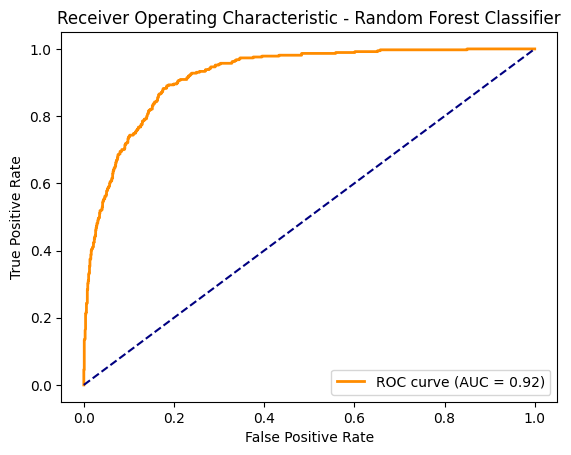

In [13]:
clf_best2 = RandomForestClassifier(max_depth = 9, min_samples_leaf = 1, n_estimators = 50, random_state = 42)

clf_best2.fit(X_train, y_train)

y_pred_proba = clf_best2.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

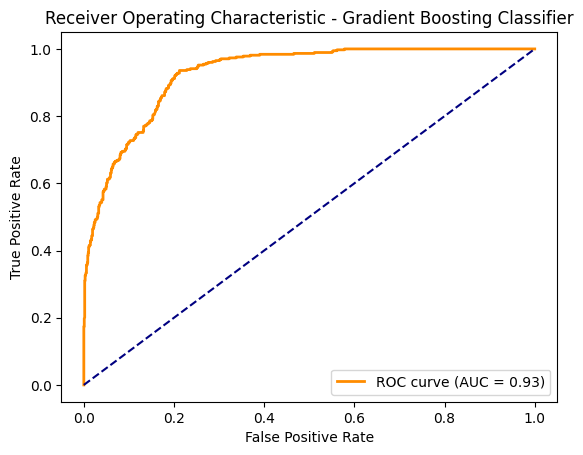

In [12]:
clf_best1 = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 5, max_features = 'sqrt',
                                    min_samples_leaf = 2, n_estimators = 150, random_state = 42)

clf_best1.fit(X_train, y_train)

y_pred_proba = clf_best1.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.show()

In [15]:
y_proba = clf_best1.predict_proba(X_test)
y_pred = clf_best1.predict(X_test)
y_pred_thresh = (y_proba[:, 1] > 0.234).astype(int)

print(f"The baseline confusion matrix is \n {confusion_matrix(y_test, y_pred)}")
print(f"The confusion matrix for the optimum threshold is \n {confusion_matrix(y_test, y_pred_thresh)}")

The baseline confusion matrix is 
 [[939  94]
 [114 260]]
The confusion matrix for the optimum threshold is 
 [[823 210]
 [ 30 344]]


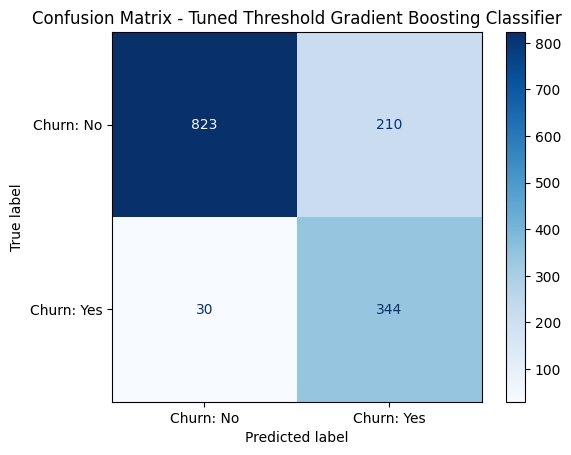

In [20]:
# Confusion Matrix for the best performing classifier

conf_matrix = np.array([[823, 210], [30, 344]])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Churn: No', 'Churn: Yes'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Tuned Threshold Gradient Boosting Classifier")
plt.show()